# Data sources are [rajeevw](https://www.kaggle.com/rajeevw/ufcdata) and [calmdownkarm](https://www.kaggle.com/calmdownkarm/ufcdataset)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
filepath = '../data/'
filename = 'data.csv'
data = pd.read_csv(filepath_or_buffer="{}{}".format(filepath, filename))
data.shape

(5144, 145)

In [3]:
list_of_variables = data.columns.tolist()
list_of_variables[:8]

['R_fighter',
 'B_fighter',
 'Referee',
 'date',
 'location',
 'Winner',
 'title_bout',
 'weight_class']

In [4]:
data.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,...,1.0,0.0,0.0,6.0,Orthodox,162.56,172.72,135.0,26.0,29.0
4,Tai Tuivasa,Blagoy Ivanov,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Blue,False,Heavyweight,3,0.0,...,2.0,0.0,0.0,3.0,Southpaw,187.96,190.50,264.0,32.0,26.0


# Insights to extract


### General stats (mostly distributions)
- Reach
- Age
- Height
- Method of win (KO, TKO, Submission, Decision - Unanimous/Split)
- Referee
- Date
- Location
- Stoppages by location (Thanks, New York)
- Number of rounds
- Number of rounds if there's a stoppage


### Stats by division
- Fights
- Reach
- Age
- Method of win (KO, TKO, Submission, Decision - Unanimous/Split)
- Stoppages by location (Thanks, New York)


### Stats by fighter
- Wins, Losses, NCs, DQs
- Fight frequency
- Title bouts
- Title defences
- Total bouts
- Stance
- TakeDown attempts vs landed (avg_TD_att vs avg_TD_landed)


> Many more detailed in-fight stats can be calculated

# Wrangling

In [5]:
def get_missing_values(df):
    """ Gets DataFrame of variables and number of values missing per variable """
    rename_dict = {
        'index': 'variable',
        0: 'num_missing_values',
        '0': 'num_missing_values'
    }
    df_missing_values = df.isnull().sum().to_frame().reset_index()
    df_missing_values.rename(mapper=rename_dict, axis=1, inplace=True)
    df_missing_values = df_missing_values[df_missing_values['num_missing_values'] > 0].reset_index(drop=True)
    return df_missing_values

In [6]:
def sort_by_date_descending(df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=False).reset_index(drop=True, inplace=True)
    return df

In [7]:
def get_fighters(df):
    """ Get list of all fighters """
    red_corner_fighters = df['R_fighter'].unique().tolist()
    blue_corner_fighters = df['B_fighter'].unique().tolist()
    fighters = sorted(list(set(red_corner_fighters + blue_corner_fighters)))
    return fighters

In [8]:
def get_fight_count_by_division(df):
    """ Get Pandas DataFrame of fight count by division """
    df_fight_count_by_division = df['weight_class'].value_counts().to_frame().reset_index()
    df_fight_count_by_division.rename({'weight_class': 'count', 'index': 'weight_class'}, axis=1, inplace=True)
    df_fight_count_by_division['sex'] = df_fight_count_by_division['weight_class'].apply(get_gender_from_weight_class)
    return df_fight_count_by_division

In [9]:
def data_by_fighters(df, fighter):
    """ Helper function to get filtered Pandas DataFrame by fighter """
    df_by_fighter = df[(df['R_fighter'] == fighter) | (df['B_fighter'] == fighter)]
    return df_by_fighter

In [10]:
def filter_by_fighters_of_interest(df, fighters_of_interest):
    """
    Definition: Filter entire DataFrame to get just the fights of fighters you're interested in
    Parameters:
        - df (Pandas DataFrame): Raw Pandas DataFrame of UFC data
        - fighters_of_interest (list): List of fighters of interest
    Returns:
        Filtered Pandas DataFrame containing just the fights of fighters you're interested in
    """
    df_by_fighters_of_interest = pd.DataFrame()
    for fighter in fighters_of_interest:
        df_by_fighter = df[(df['R_fighter'] == fighter) | (df['B_fighter'] == fighter)]
        df_by_fighters_of_interest = pd.concat(objs=[df_by_fighters_of_interest, df_by_fighter],
                                               ignore_index=True, sort=False)
    return df_by_fighters_of_interest

In [11]:
def get_distributions(df):
    """ Get distributions of age, weight, height, reach. Returns dictionary of all variables' distributions """
    distribution_dict = dict()
    df_temp = df.copy()
    age = df_temp['R_age'].dropna().to_list() + df_temp['B_age'].dropna().to_list()
    height = df_temp['R_Height_cms'].dropna().to_list() + df_temp['B_Height_cms'].dropna().to_list()
    weight = df_temp['R_Weight_lbs'].dropna().to_list() + df_temp['B_Weight_lbs'].dropna().to_list()
    reach = df_temp['R_Reach_cms'].dropna().to_list() + df_temp['B_Reach_cms'].dropna().to_list()
    distribution_dict['age'] = age
    distribution_dict['height'] = height
    distribution_dict['weight'] = weight
    distribution_dict['reach'] = reach
    return distribution_dict

In [12]:
def get_stance(df, fighter):
    df_stances = data_by_fighters(df=df, fighter=fighter)
    df_stances_red = df_stances[df_stances['R_fighter'] == fighter]
    df_stances_blue = df_stances[df_stances['B_fighter'] == fighter]
    stances = df_stances_red['R_Stance'].value_counts() + df_stances_blue['B_Stance'].value_counts()
    try:
        return stances.index[0]
    except IndexError as e:
        print("IndexError in stance for fighter: {}".format(fighter))
        return 'unknown'

In [13]:
def get_record(df, fighter):
    """ Get record by fighter. Returns dictionary of fights, wins, losses, no-contests, and percentages """
    df_fighter = data_by_fighters(df=df, fighter=fighter)
    fights = len(df_fighter)
    win_as_red = (df_fighter['R_fighter'] == fighter) & (df_fighter['Winner'] == 'Red')
    win_as_blue = (df_fighter['B_fighter'] == fighter) & (df_fighter['Winner'] == 'Blue')
    lose_as_red = (df_fighter['R_fighter'] == fighter) & (df_fighter['Winner'] == 'Blue')
    lose_as_blue = (df_fighter['B_fighter'] == fighter) & (df_fighter['Winner'] == 'Red')
    df_wins = df_fighter[win_as_red | win_as_blue]
    df_losses = df_fighter[lose_as_red | lose_as_blue]
    no_contest = 0
    for result in df_fighter['Winner'].tolist():
        if result.strip().lower() not in ['red', 'blue']:
            no_contest += 1
    wins = len(df_wins)
    losses = len(df_losses)
    nc_percent = round((no_contest * 100 / fights), 2)
    win_percent = round((wins * 100 / fights), 2)
    loss_percent = round(100 - win_percent - nc_percent, 2)
    record_dict = dict()
    record_dict['fighter'] = fighter
    record_dict['fights'] = fights
    record_dict['wins'] = wins
    record_dict['losses'] = losses
    record_dict['no_contest'] = no_contest
    record_dict['win_percent'] = win_percent
    record_dict['loss_percent'] = loss_percent
    record_dict['nc_percent'] = nc_percent
    return record_dict

In [14]:
def get_fight_frequency(df, fighter, by='days'):
    """
    Definition: Get fight frequency by fighter (in days or months).
    Parameters:
        - df (Pandas DataFrame): Raw Pandas DataFrame of UFC data
        - fighter (string): Name of fighter
        - by (string): Options are ['days', 'months']. Default: 'days'
    Returns:
        Average number of days/months between consecutive fights (int or float)
    """
    df_fighter = data_by_fighters(df=df, fighter=fighter)
    df_fighter['date'] = pd.to_datetime(df_fighter['date'])
    fights = len(df_fighter)
    first = df_fighter['date'].iloc[0]
    last = df_fighter['date'].iloc[-1]
    date_difference = abs((first - last).days)
    fight_frequency = round(date_difference / fights, 2)
    if by == 'days':
        return fight_frequency
    elif by == 'months':
        fight_frequency = round(fight_frequency / 30, 2)
        return fight_frequency

In [15]:
def get_location_counts(df):
    df_locations = df.drop_duplicates(subset=['date'], keep='first')['location'].value_counts().to_frame().reset_index()
    df_locations.rename({'location': 'count', 'index': 'location'}, axis=1, inplace=True)
    return df_locations

In [16]:
def get_gender_from_weight_class(weight_class_series):
    """ Helper function that can be used with pd.apply() on the 'weight_class' column - to get gender of fighters """
    division = weight_class_series.strip().lower()
    if 'women' in division:
        return 'Female'
    return 'Male'

In [17]:
def get_percent_of_title_bouts_by_division(df):
    df_percent_title_bouts = (df.groupby(by='weight_class')['title_bout'].mean() * 100).to_frame()
    df_percent_title_bouts.rename({'title_bout': 'percent_title_bouts'}, axis=1, inplace=True)
    df_percent_title_bouts['percent_title_bouts'] = df_percent_title_bouts['percent_title_bouts'].apply(round, args=[2])
    df_percent_title_bouts.sort_values(by='percent_title_bouts', ascending=False, inplace=True)
    df_percent_title_bouts = df_percent_title_bouts.reset_index()
    df_percent_title_bouts['sex'] = df_percent_title_bouts['weight_class'].apply(get_gender_from_weight_class)
    return df_percent_title_bouts

In [18]:
def get_win_method(df, fighter):
    """ Returns dictionary of method of wins in all UFC fights for said fighter """
    rename_red = {
        'R_fighter': 'fighter',
        'R_win_by_Decision_Majority': 'win_by_Decision_Majority',
        'R_win_by_Decision_Split': 'win_by_Decision_Split',
        'R_win_by_Decision_Unanimous': 'win_by_Decision_Unanimous',
        'R_win_by_KO/TKO': 'win_by_KO/TKO',
        'R_win_by_Submission': 'win_by_Submission',
        'R_win_by_TKO_Doctor_Stoppage': 'win_by_TKO_Doctor_Stoppage',
        'R_wins': 'wins',
        'R_losses': 'losses'
    }
    rename_blue = {
        'B_fighter': 'fighter',
        'B_win_by_Decision_Majority': 'win_by_Decision_Majority',
        'B_win_by_Decision_Split': 'win_by_Decision_Split',
        'B_win_by_Decision_Unanimous': 'win_by_Decision_Unanimous',
        'B_win_by_KO/TKO': 'win_by_KO/TKO',
        'B_win_by_Submission': 'win_by_Submission',
        'B_win_by_TKO_Doctor_Stoppage': 'win_by_TKO_Doctor_Stoppage',
        'B_wins': 'wins',
        'B_losses': 'losses'
    }
    df_fighter = data_by_fighters(df=df, fighter=fighter)
    df_fighter_latest_fight = df_fighter.head(1)
    if df_fighter_latest_fight['R_fighter'].iloc[0] == fighter:
        df_fighter_latest_fight.rename(rename_red, axis=1, inplace=True)
        df_fighter_latest_stats = df_fighter_latest_fight.loc[:, rename_red.values()]
        return df_fighter_latest_stats.iloc[0].to_dict()
    elif df_fighter_latest_fight['B_fighter'].iloc[0] == fighter:
        df_fighter_latest_fight.rename(rename_blue, axis=1, inplace=True)
        df_fighter_latest_stats = df_fighter_latest_fight.loc[:, rename_blue.values()]
        return df_fighter_latest_stats.iloc[0].to_dict()

In [19]:
def get_referee_appearances(df, normalize=False):
    """ Get count/percentage of referee appearances """
    if normalize:
        df_referee_appearances = (df['Referee'].value_counts(normalize=True) * 100).reset_index()
        variable_name = 'percent_appearances'
    else:
        df_referee_appearances = df['Referee'].value_counts().reset_index()
        variable_name = 'count_appearances'
    df_referee_appearances.rename({'Referee': variable_name, 'index': 'referee'}, axis=1, inplace=True)
    return df_referee_appearances

In [20]:
def get_location_details(location):
    location_dict = dict()
    location = str(location).strip()
    location_list = location.split(', ')
    city = location_list[0]
    country = location_list[-1]
    location_dict['city'] = city
    location_dict['country'] = country
    if len(location_list) == 3:
        state = location_list[1] # The state isn't always mentioned
        location_dict['state'] = state
    return location_dict['country']


def get_location_counts(df):
    df_locations = df.drop_duplicates(subset=['date'], keep='first')['location'].value_counts().to_frame().reset_index()
    df_locations.rename({'location': 'count', 'index': 'location'}, axis=1, inplace=True)
    df_locations['country'] = df_locations['location'].apply(get_location_details)
    return df_locations


def get_country_located(df_location):
    df_location_by_country = df_location['country'].value_counts().to_frame().reset_index()
    df_location_by_country.rename({'country': 'count', 'index': 'country'}, axis=1, inplace=True)
    return df_location_by_country

In [21]:
def plot_distributions(df):
    """ Plot distributions of age, height, weight, reach """
    distributions = get_distributions(df=df)
    color_dict = {
        'age': '#D6442D',
        'height': '#2DD69F',
        'weight': '#3A2B73',
        'reach': '#29922A'
    }
    label_dict = {
        'age': 'years',
        'height': 'cms',
        'weight': 'lbs',
        'reach': 'cms'
    }

    for feature in distributions.keys():
        distribution = distributions[feature]
        title = "UFC - {} distribution".format(feature.capitalize())
        plt.figure(figsize=(25, 14))
        plt.hist(x=distribution, color=color_dict[feature])
        plt.title(title, fontsize=40)
        plt.xlabel("{} (in {})".format(feature, label_dict[feature]), fontsize=30)
        plt.ylabel("count", fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        if feature == 'weight':
            plt.xlim(min(distribution) - 10, 300)
        plt.show()

In [22]:
def plot_bar_chart(data, title, x, y, hue=None, color=None):
    plt.figure(figsize=(25,14))
    sns.barplot(x=x, y=y, hue=hue, data=data, color=color)
    plt.title(title, fontsize=40)
    plt.xlabel(x, fontsize=30)
    plt.ylabel(y, fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    for i, v in enumerate(data[x]):
        plt.text(x = v + 0.4, y = i, s = str(v), fontweight='bold', fontsize=24, color='black')
    if hue:
        plt.legend(loc='best', fontsize=20)
    plt.show()

In [23]:
fighters_of_interest = [
    'Conor McGregor', 'Khabib Nurmagomedov', 'Tony Ferguson', 'Dustin Poirier', 'Jon Jones', 'Henry Cejudo',
    'Stipe Miocic', 'Daniel Cormier', 'Israel Adesanya', 'Kamaru Usman', 'Alexander Volkanovski', 'Max Holloway',
    'Tyron Woodley', 'Robert Whittaker', 'Jorge Masvidal', 'Joseph Benavidez', 'Marlon Moraes', 'Petr Yan', 'Jose Aldo',
    'Brian Ortega', 'Zabit Magomedsharipov', 'Chan Sung Jung', 'Frankie Edgar', 'Donald Cerrone', 'Kevin Lee',
    'Islam Makhachev', 'Colby Covington', 'Nate Diaz', 'Paulo Costa', 'Yoel Romero', 'Kelvin Gastelum', 'Thiago Santos',
    'Dominick Reyes', 'Alexander Gustafsson', 'Francis Ngannou', 'Curtis Blaydes', 'Junior Dos Santos', 'Alistair Overeem',
    'Amanda Nunes', 'Valentina Shevchenko', 'Zhang Weili', 'Jessica Andrade', 'Rose Namajunas', 'Joanna Jedrzejczyk',
    'Holly Holm'
]

len(fighters_of_interest)

45

In [24]:
%%time

data = sort_by_date_descending(df=data)
data = filter_by_fighters_of_interest(df=data, fighters_of_interest=fighters_of_interest)

df_locations = get_location_counts(df=data)
df_locations_by_country = get_country_located(df_location=df_locations)
df_referee_appearances = get_referee_appearances(df=data, normalize=False)
df_fight_count_by_division = get_fight_count_by_division(df=data)
df_title_bouts_by_division = get_percent_of_title_bouts_by_division(df=data)

Wall time: 649 ms


In [25]:
%%time

# fighters = get_fighters(df=data)
df_stats = pd.DataFrame()
for fighter in fighters_of_interest:
    try:
        dict_record = get_record(df=data, fighter=fighter)
        dict_win_method = get_win_method(df=data, fighter=fighter)
        stance = get_stance(df=data, fighter=fighter)
        fight_frequency = get_fight_frequency(df=data, fighter=fighter, by='months')

        # Put the stats into a single DataFrame
        df_stat_record = pd.DataFrame(data=dict_record, index=[0])
        df_stat_win_method = pd.DataFrame(data=dict_win_method, index=[0])
        df_stat = pd.merge(left=df_stat_record, right=df_stat_win_method, on='fighter', how='outer')
        df_stat['stance'] = stance
        df_stat['fight_frequency'] = fight_frequency
        df_stats = pd.concat(objs=[df_stats, df_stat], ignore_index=True, sort=False)
    except ZeroDivisionError:
        print("ZeroDivisionError for fighter: {}".format(fighter))
df_stats.sort_values(by='win_percent', ascending=False, inplace=True)
df_stats.reset_index(drop=True, inplace=True)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


IndexError in stance for fighter: Paulo Costa
ZeroDivisionError for fighter: Zhang Weili
Wall time: 2.56 s


# Plotting

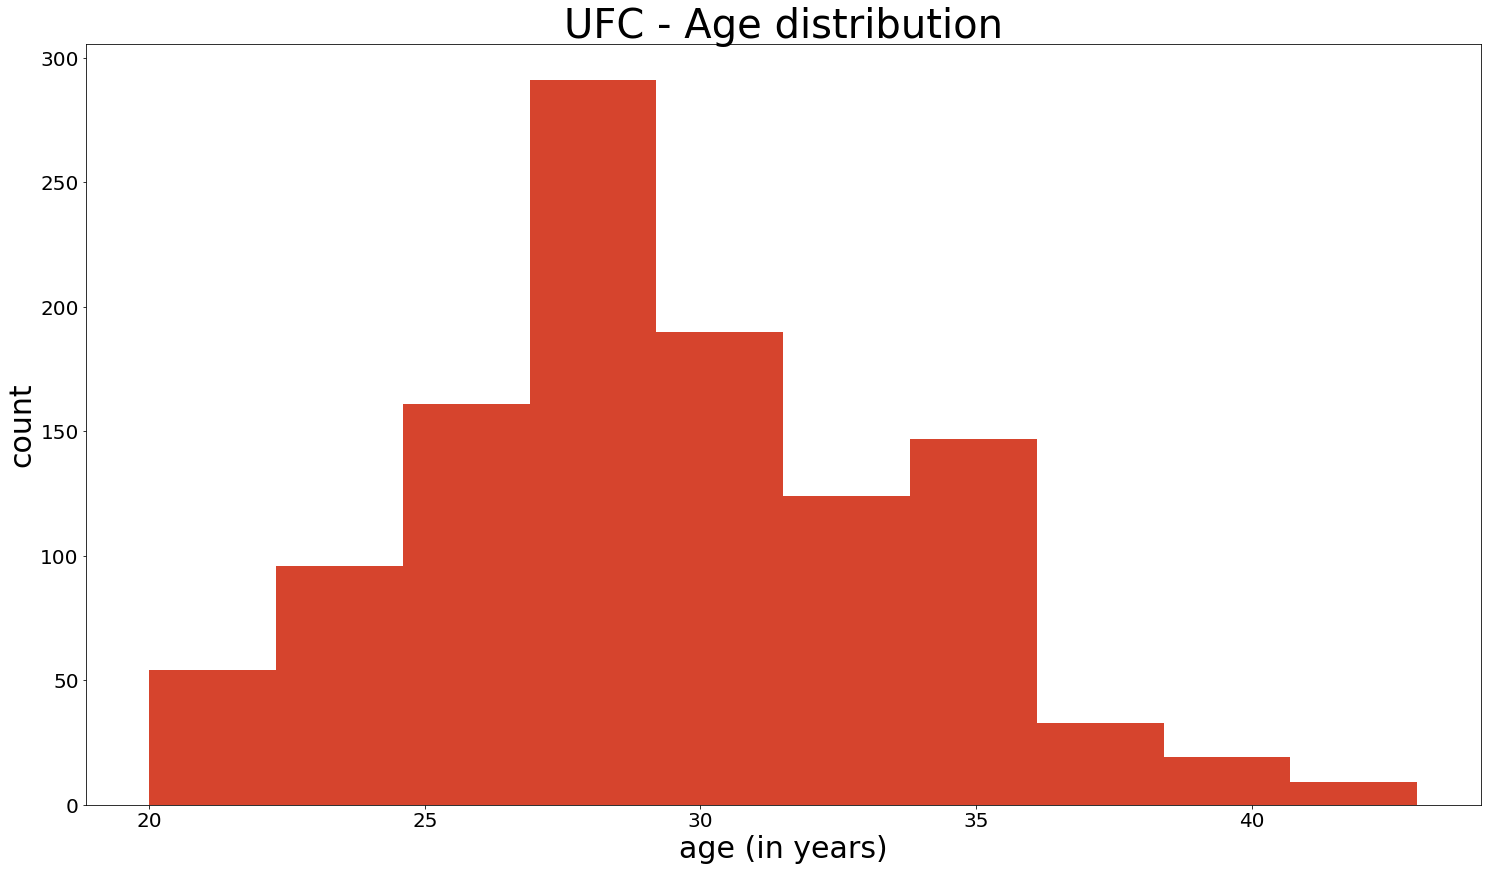

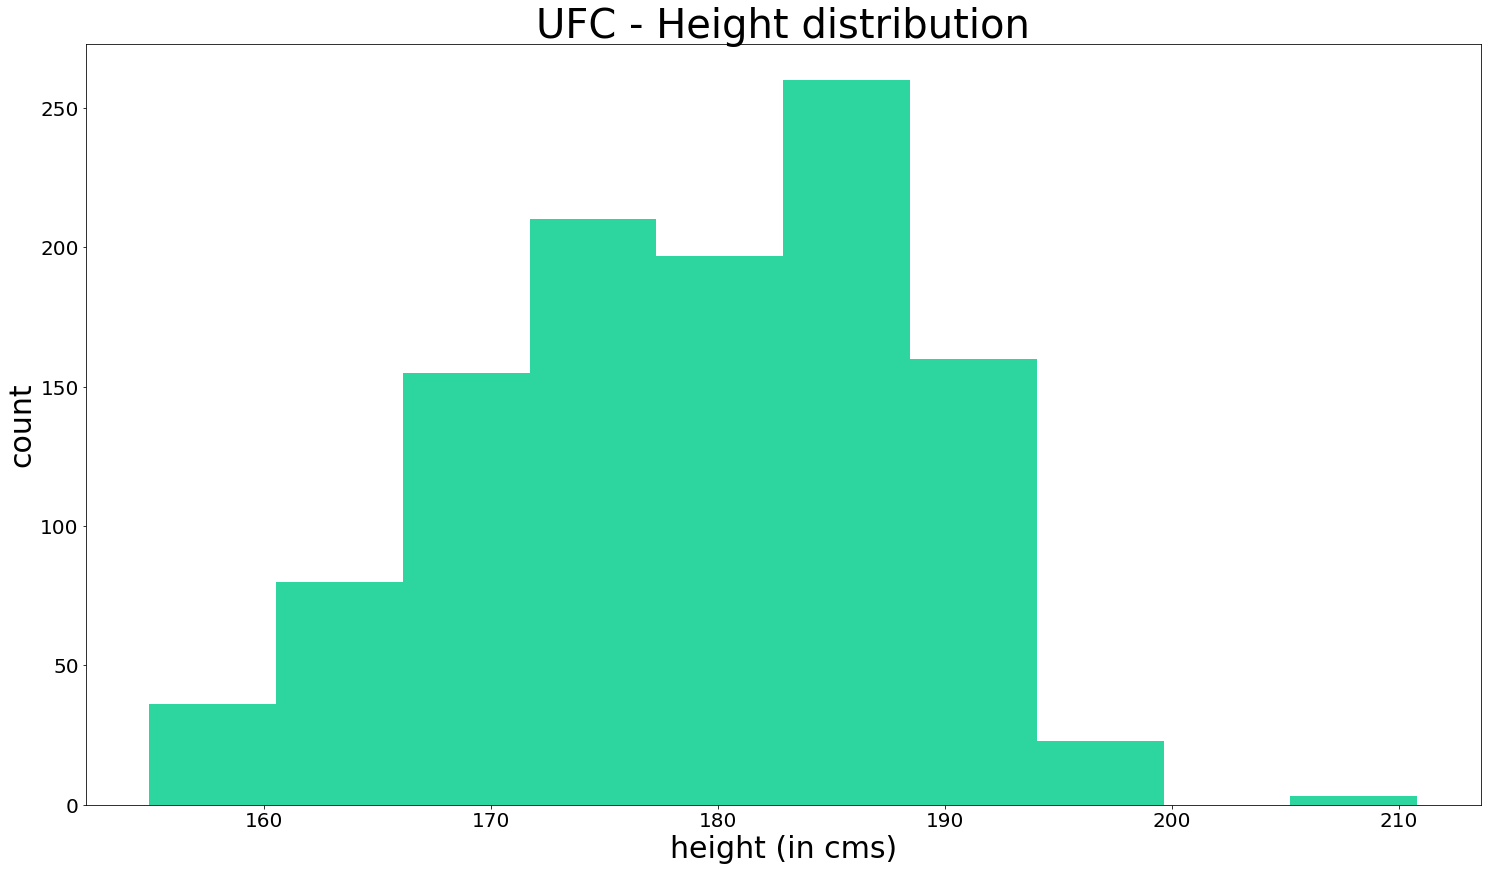

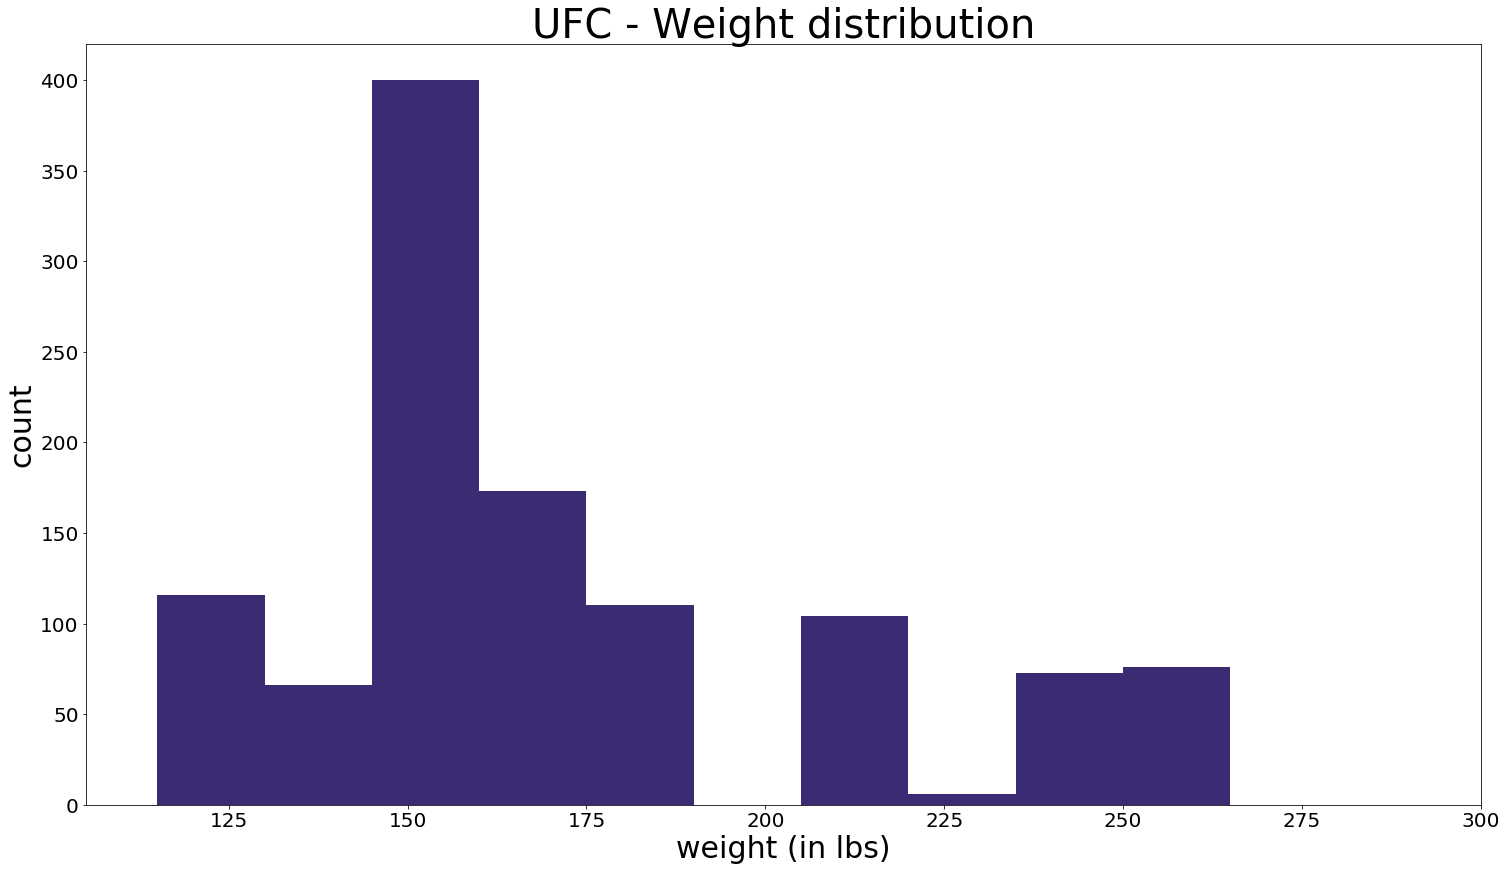

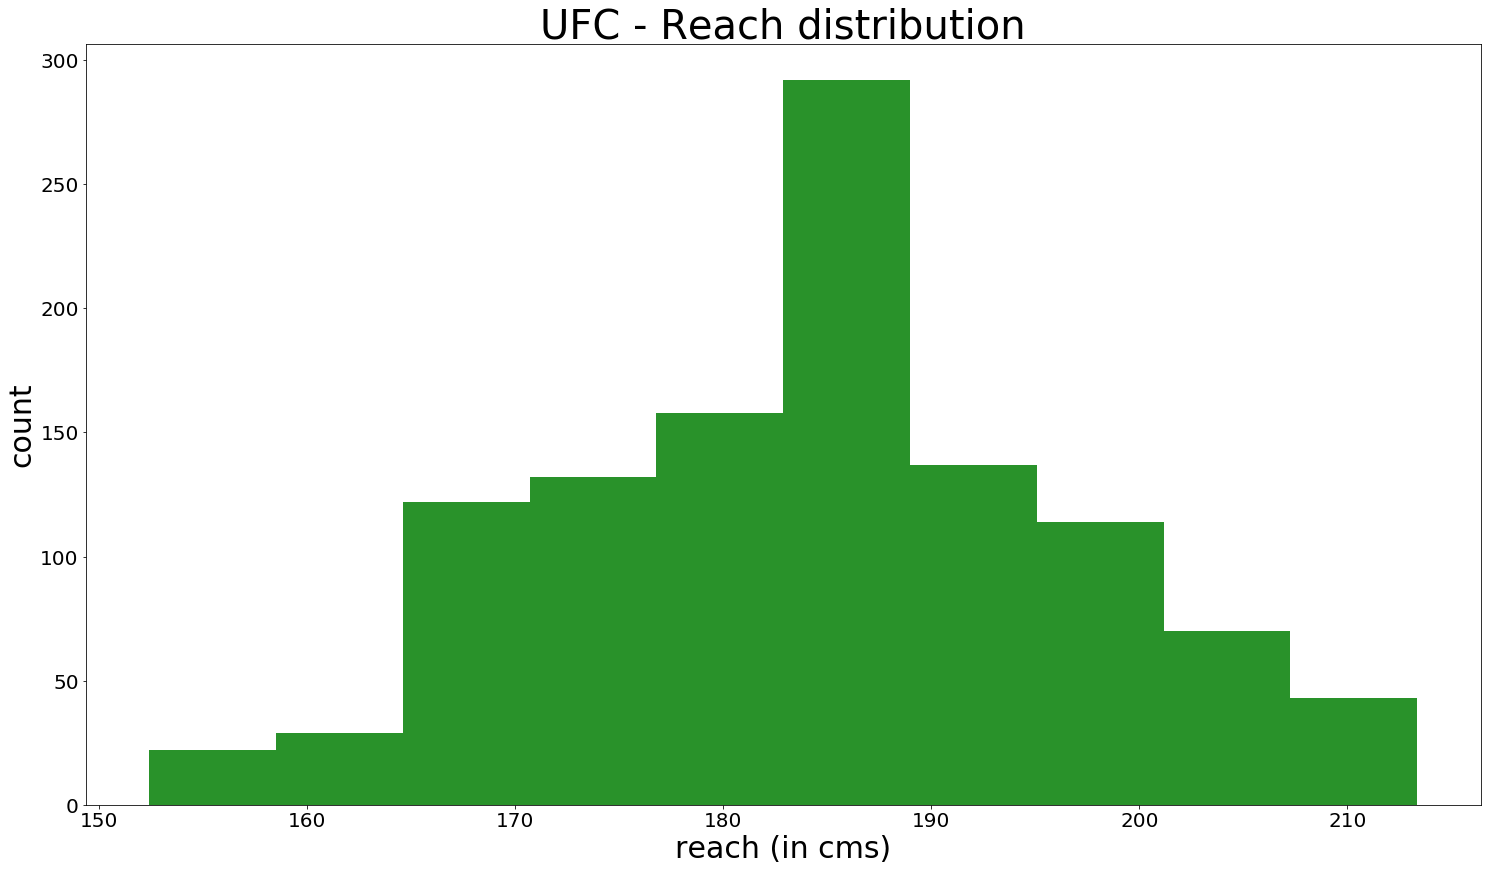

In [26]:
plot_distributions(df=data)

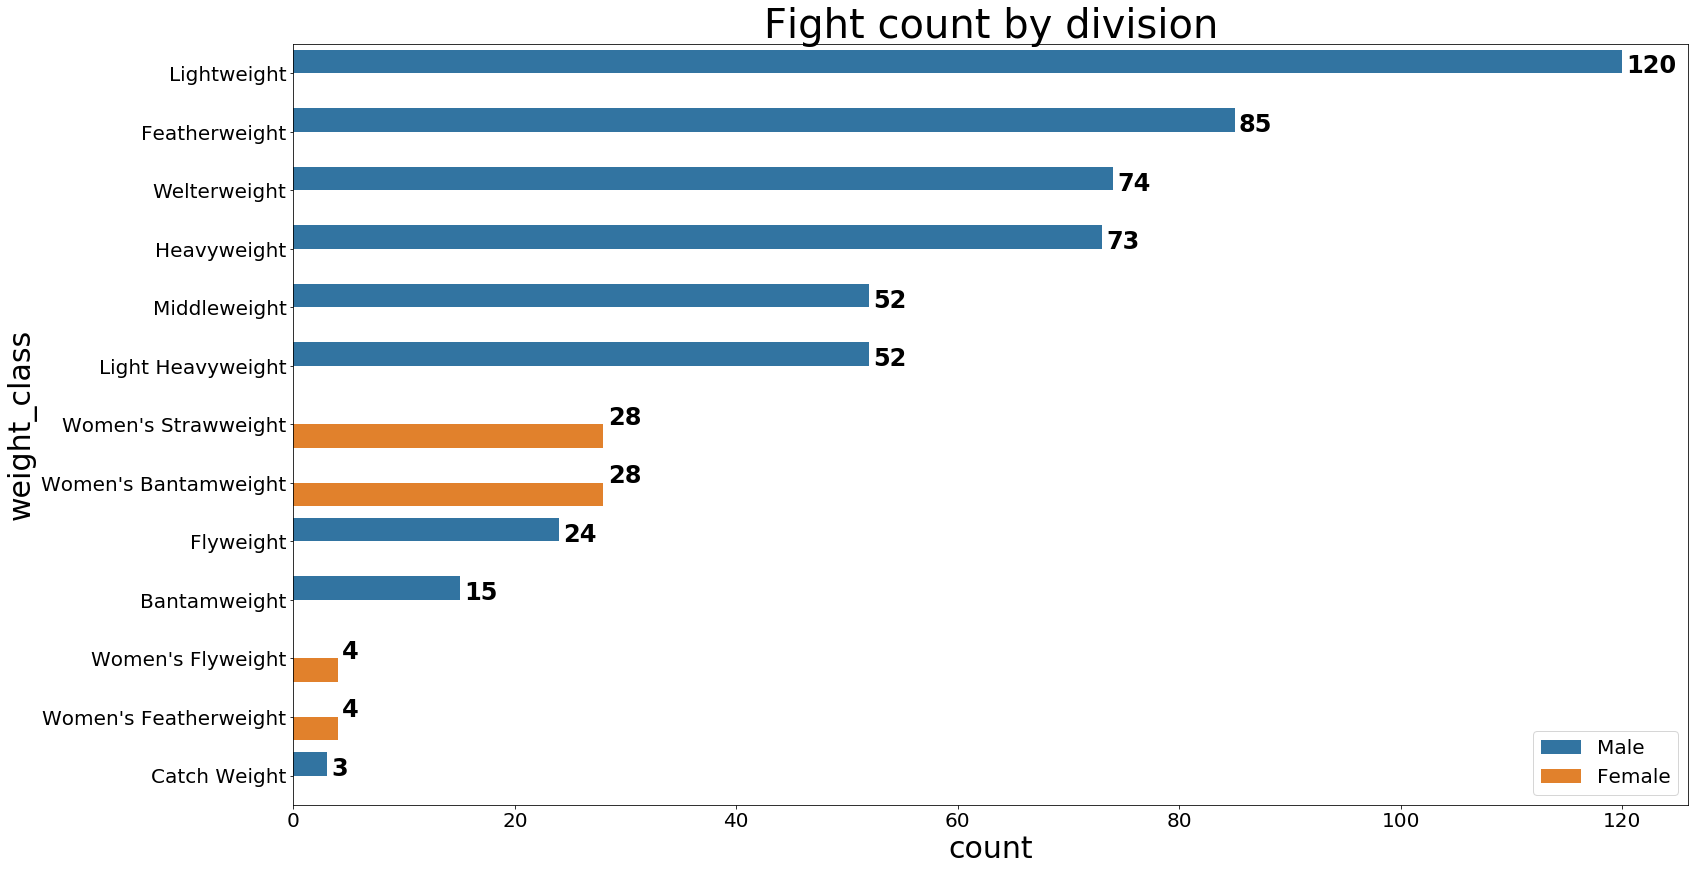

In [27]:
plot_bar_chart(data=df_fight_count_by_division, title="Fight count by division",
               x='count', y='weight_class', hue='sex')

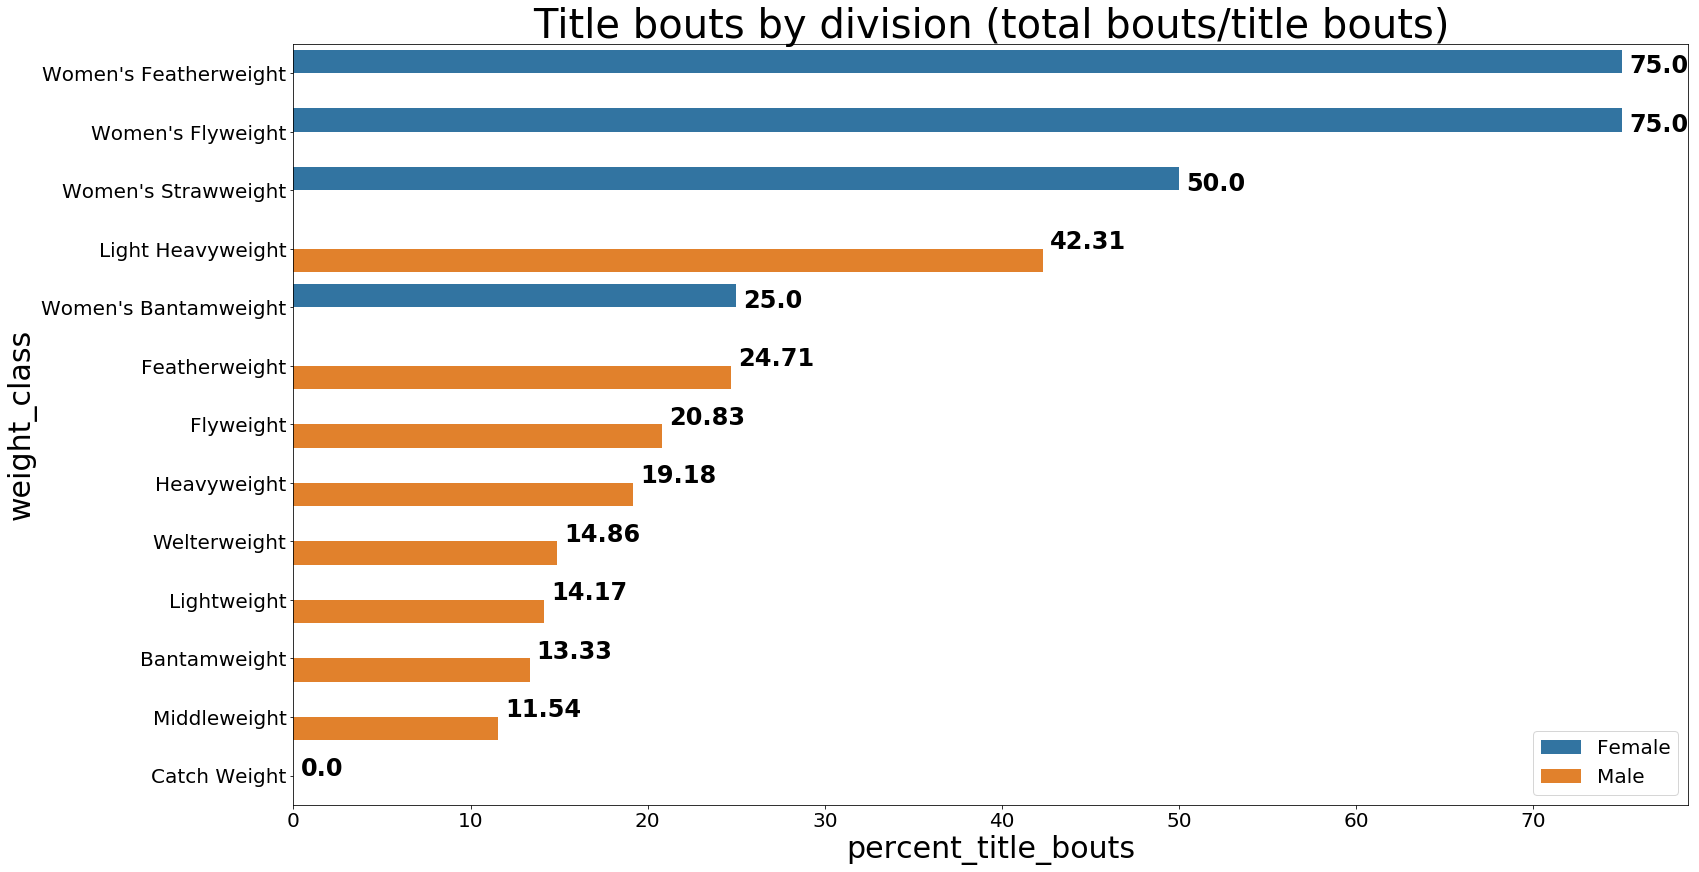

In [28]:
plot_bar_chart(data=df_title_bouts_by_division, title="Title bouts by division (total bouts/title bouts)",
               x='percent_title_bouts', y='weight_class', hue='sex')

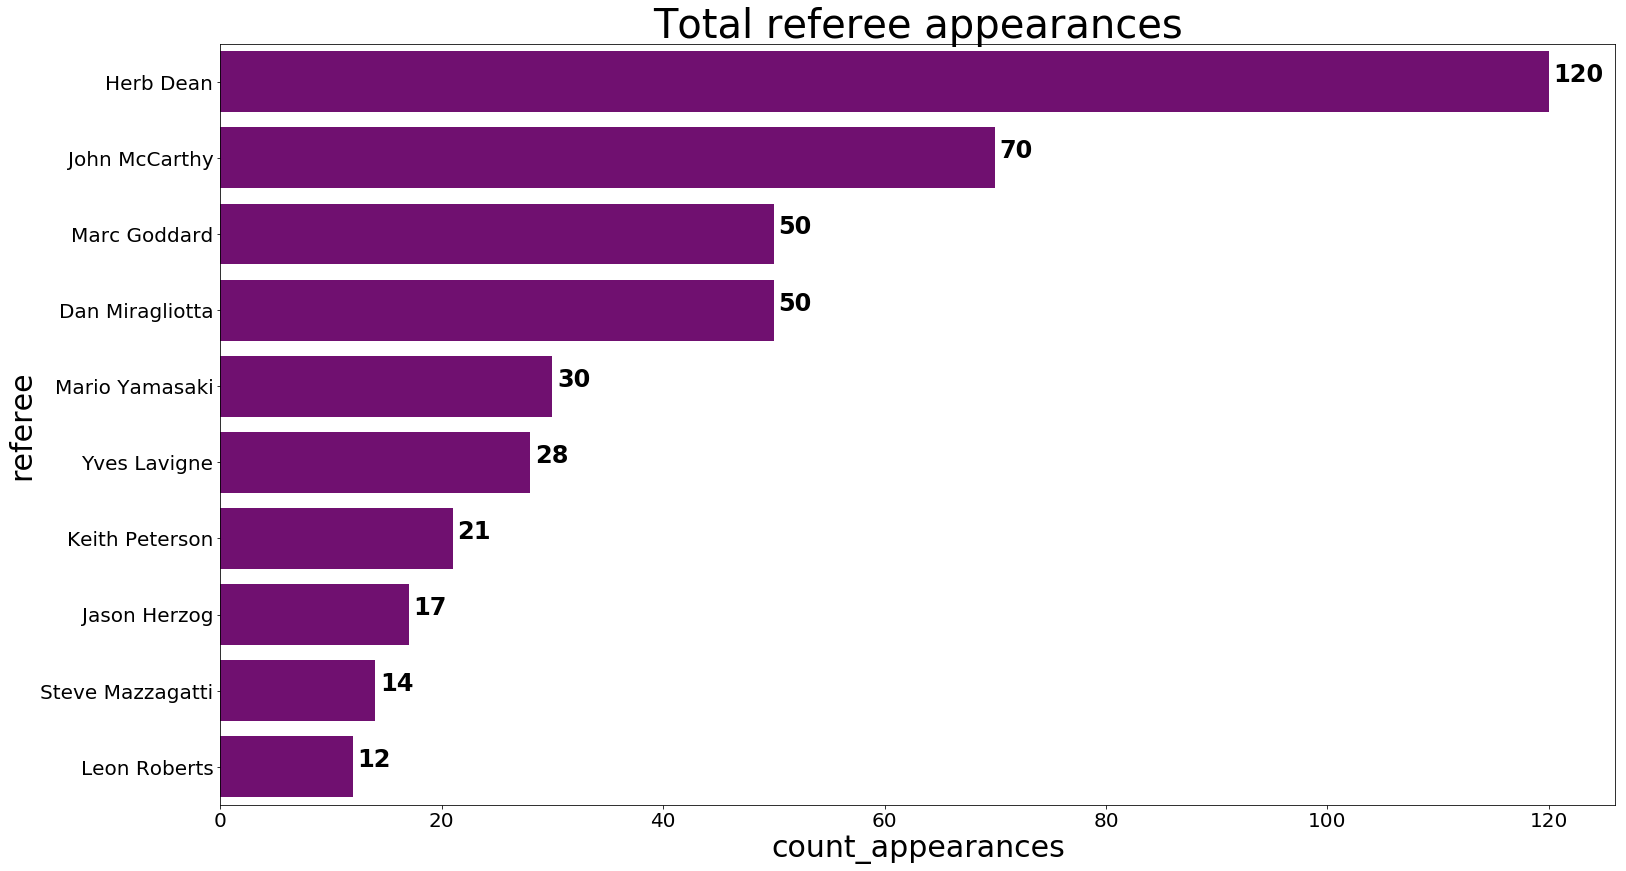

In [29]:
plot_bar_chart(data=df_referee_appearances.head(10), title="Total referee appearances",
               x='count_appearances', y='referee', color='purple')

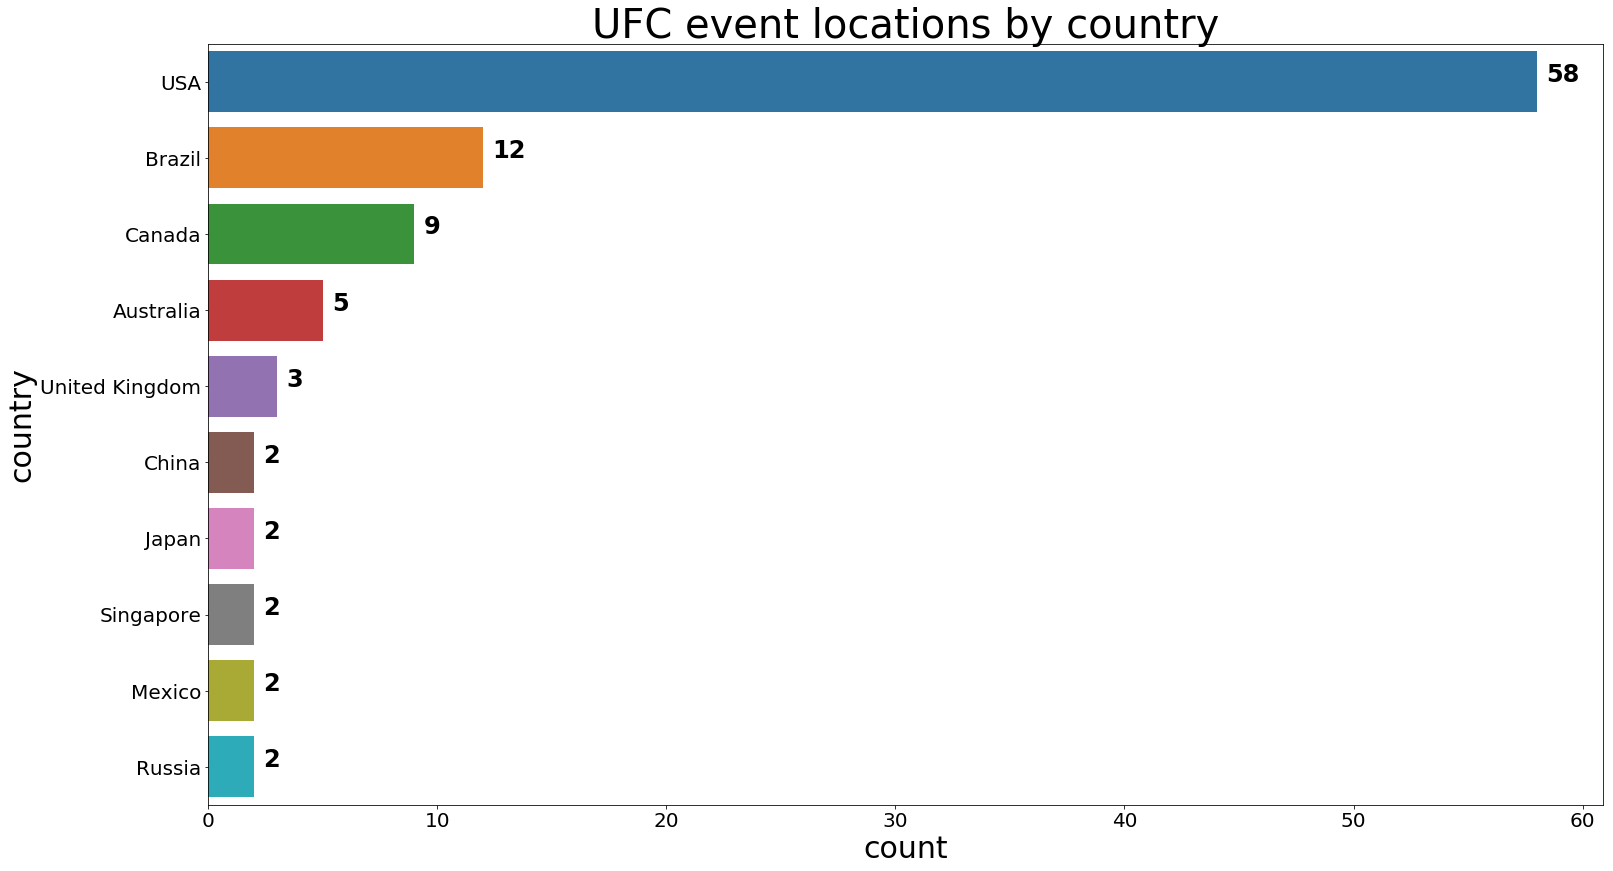

In [30]:
plot_bar_chart(data=df_locations_by_country.head(10), title="UFC event locations by country",
               x='count', y='country', color=None)

# Insights

In [31]:
df_locations.head(8)

,location,count,country
0,"Las Vegas, Nevada, USA",66,USA
1,"Stockholm, Sweden",6,Sweden
2,"Newark, New Jersey, USA",6,USA
3,"Toronto, Ontario, Canada",6,Canada
4,"Chicago, Illinois, USA",5,USA
5,"Dallas, Texas, USA",5,USA
6,"London, England, United Kingdom",5,United Kingdom
7,"Denver, Colorado, USA",4,USA


In [32]:
df_locations_by_country.head(8)

,country,count
0,USA,58
1,Brazil,12
2,Canada,9
3,Australia,5
4,United Kingdom,3
5,China,2
6,Japan,2
7,Singapore,2


In [33]:
df_referee_appearances.head(10)

,referee,count_appearances
0,Herb Dean,120
1,John McCarthy,70
2,Marc Goddard,50
3,Dan Miragliotta,50
4,Mario Yamasaki,30
5,Yves Lavigne,28
6,Keith Peterson,21
7,Jason Herzog,17
8,Steve Mazzagatti,14
9,Leon Roberts,12


In [34]:
df_fight_count_by_division

,weight_class,count,sex
0,Lightweight,120,Male
1,Featherweight,85,Male
2,Welterweight,74,Male
3,Heavyweight,73,Male
4,Middleweight,52,Male
5,Light Heavyweight,52,Male
6,Women's Strawweight,28,Female
7,Women's Bantamweight,28,Female
8,Flyweight,24,Male
9,Bantamweight,15,Male


In [35]:
df_title_bouts_by_division

,weight_class,percent_title_bouts,sex
0,Women's Featherweight,75.00,Female
1,Women's Flyweight,75.00,Female
2,Women's Strawweight,50.00,Female
3,Light Heavyweight,42.31,Male
4,Women's Bantamweight,25.00,Female
5,Featherweight,24.71,Male
6,Flyweight,20.83,Male
7,Heavyweight,19.18,Male
8,Welterweight,14.86,Male
9,Lightweight,14.17,Male


In [36]:
df_stats

,fighter,fights,wins_x,losses_x,no_contest,win_percent,loss_percent,nc_percent,win_by_Decision_Majority,win_by_Decision_Split,win_by_Decision_Unanimous,win_by_KO/TKO,win_by_Submission,win_by_TKO_Doctor_Stoppage,wins_y,losses_y,stance,fight_frequency
0,Khabib Nurmagomedov,12,12,0,0,100.00,0.00,0.00,0.0,0.0,6.0,2.0,2.0,0.0,10.0,0.0,Orthodox,6.81
1,Zabit Magomedsharipov,5,5,0,0,100.00,0.00,0.00,0.0,0.0,1.0,0.0,3.0,0.0,4.0,0.0,Orthodox,3.64
2,Paulo Costa,4,4,0,0,100.00,0.00,0.00,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,unknown,4.03
3,Alexander Volkanovski,8,8,0,0,100.00,0.00,0.00,0.0,0.0,3.0,3.0,0.0,0.0,6.0,0.0,Orthodox,0.00
4,Kamaru Usman,11,11,0,0,100.00,0.00,0.00,0.0,0.0,7.0,1.0,1.0,0.0,9.0,0.0,Switch,0.00
5,Petr Yan,5,5,0,0,100.00,0.00,0.00,0.0,0.0,2.0,2.0,0.0,0.0,4.0,0.0,Switch,2.33
6,Israel Adesanya,7,7,0,0,100.00,0.00,0.00,0.0,1.0,2.0,2.0,0.0,0.0,5.0,0.0,Switch,0.00
7,Dominick Reyes,4,4,0,0,100.00,0.00,0.00,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,Southpaw,3.91
8,Tony Ferguson,18,17,1,0,94.44,5.56,0.00,0.0,1.0,3.0,3.0,6.0,1.0,14.0,1.0,Orthodox,1.13
9,Amanda Nunes,13,12,1,0,92.31,7.69,0.00,0.0,1.0,1.0,5.0,2.0,0.0,9.0,1.0,Orthodox,2.64
